# Import Libraries

In [1]:
import time
import os
# Simple file path extractor
import glob

# Matrice Operations
import numpy as np
# Image Processing
import cv2

# Visualizing Images
import matplotlib.pyplot as plt
# Visualizing 3D Plots
from mpl_toolkits.mplot3d import Axes3D
# Display plots in notebook
%matplotlib inline

# Hog Features Extractor
from skimage.feature import hog
# Data Normalization
from sklearn.preprocessing import StandardScaler
# Data Split
from sklearn.model_selection import train_test_split
# Linear SVM
from sklearn.svm import LinearSVC
from scipy.ndimage import label

# Will stick with cv2.imread() for scaling consistency
# import matplotlib.image as mpimg

/home/lethai/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.17.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Reading Images

In [2]:
def imread(image_path):
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image

## Drawing Boxes

Ham de ve cac hinh chu nhat xung quanh xe o to duoc phat hien

In [3]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        
    # Return the image copy with boxes drawn
    return imcopy

Test boxes drawing

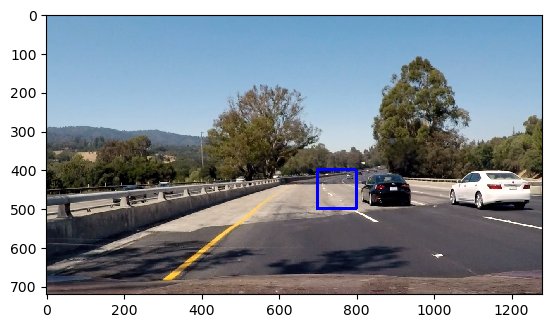

In [4]:
image = imread('test_images/test4.jpg')


bboxes = [((800, 400), (700, 500))]

result = draw_boxes(image, bboxes)
plt.imshow(result)

plt.imsave("output_images/drawing_boxes.png", result)

## Histograms of Color

Tinh toan histogram cua 3 kenh mau moi anh

In [5]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    # If you want to return just the hist_features
    #return hist_features
    
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges) - 1]) / 2
    
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

Test color histograms:

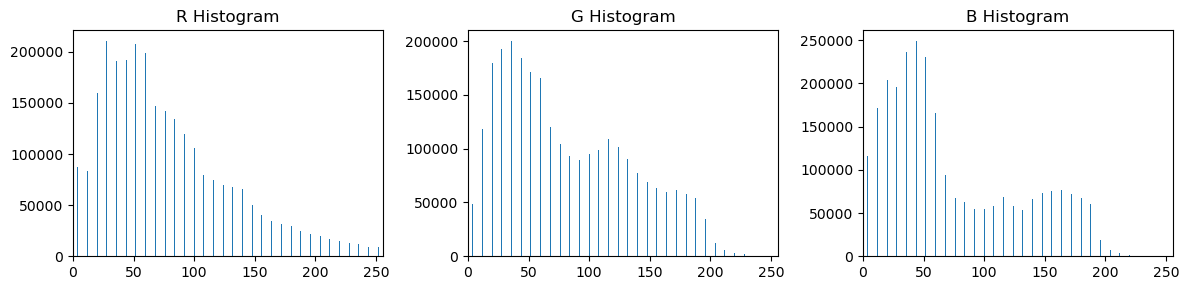

In [106]:
image = imread('test_images/11.jpg')

rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

In [7]:
# Read a color image
img = imread('test_images/test4.jpg')

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

## Spatial Binning of Color
Histograms of raw pixel values can be used as features for image recognition:

In [6]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    if color_space != 'RGB':
        
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            
    else:
        feature_image = np.copy(img)             
    features = cv2.resize(feature_image, size).ravel() 
    return features

## HOG Features

Extract Histogram of Oriented Gradient features

In [7]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    
    # two outputs 
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

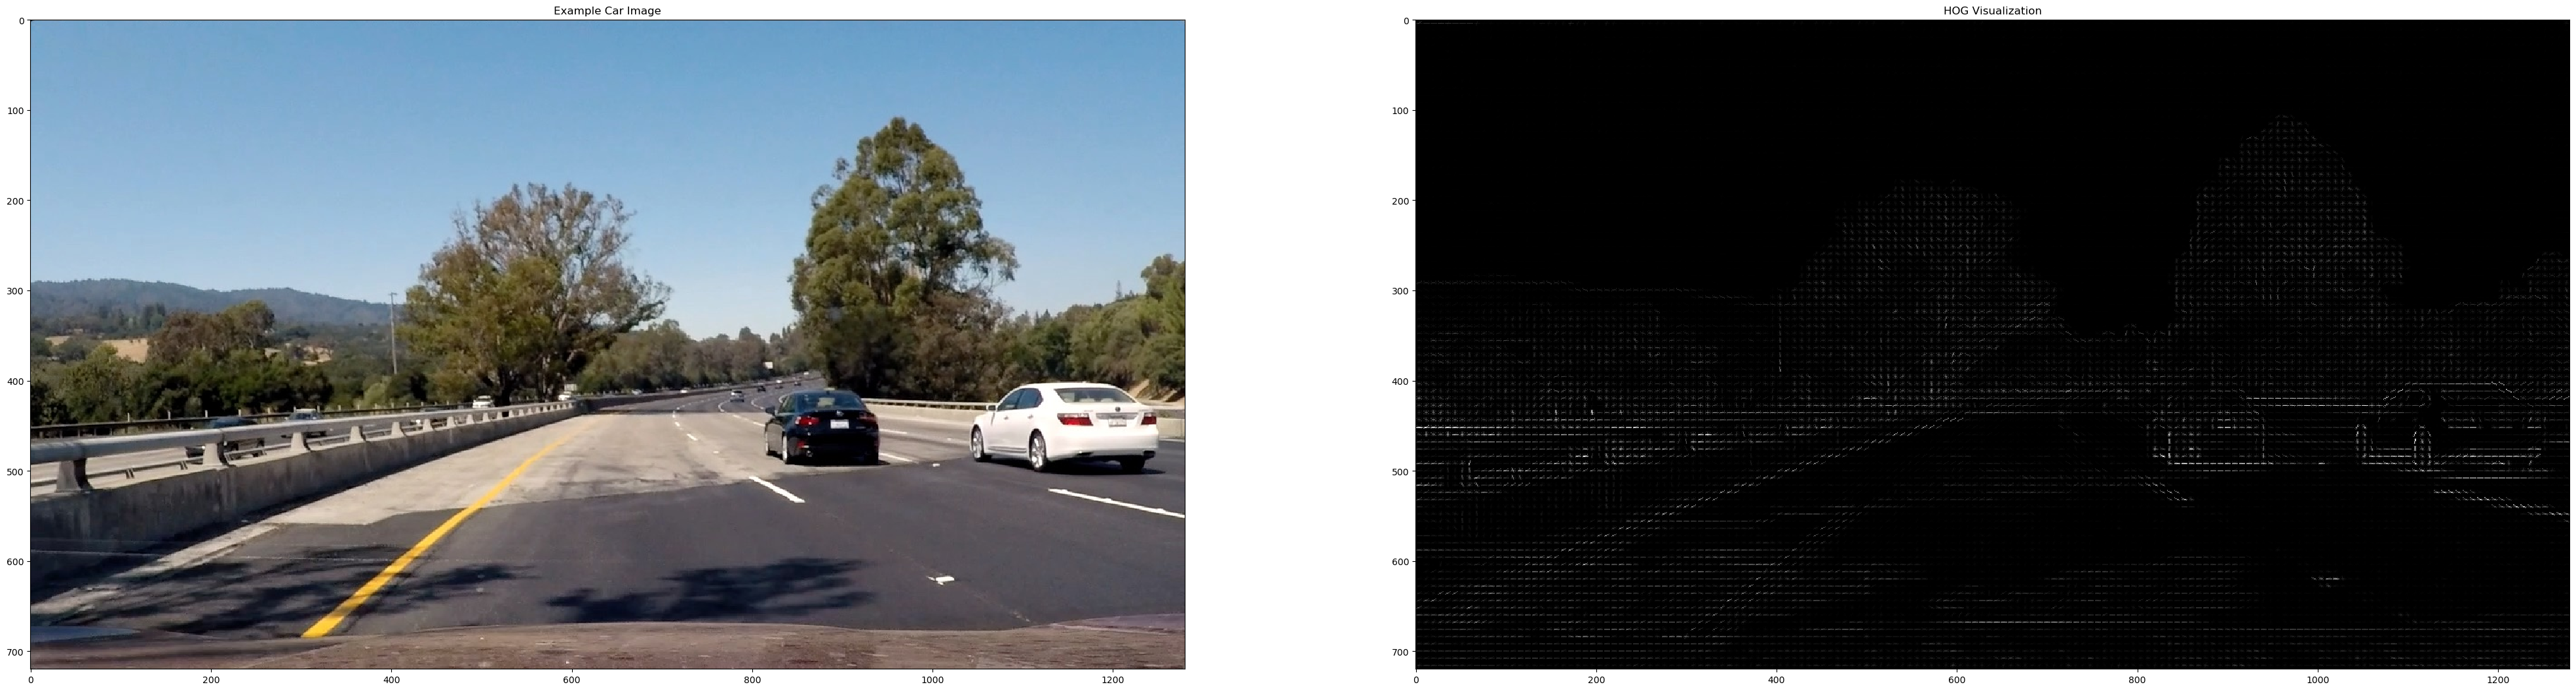

In [133]:
image = imread('test_images/test4.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# HOG parameters

orient = 9
pix_per_cell = 8
cell_per_block = 2
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

fig = plt.figure(figsize=(50, 40))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

plt.imsave("output_images/feature_vec.png", hog_image)

## Feature Extraction

Using for a list of image, combine all above histogram function

In [8]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    features = []
    
    for file in imgs:
        
        file_features = []
        image = imread(file)
        
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            # Apply bin_spatial()
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)      
                
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                
            # Append the new feature vector to the features list
            file_features.append(hog_features)
            
        features.append(np.concatenate(file_features))

    return features

## Sliding Window

Define a function that takes an image, start and stop positions in both x and y, window size (x and y dimensions), and overlap fraction (for both x and y), and returns a windows list 

In [9]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

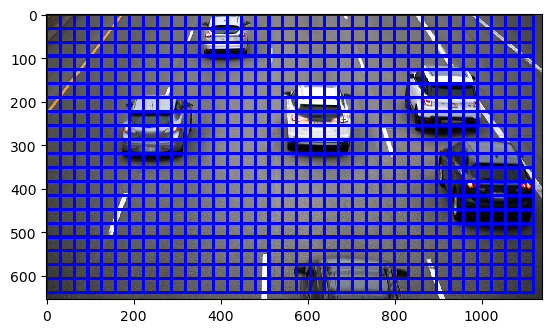

In [12]:
image = imread('test_images/14.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.imsave("output_images/sliding_windows.png", window_img)

# Vehicle Detection

### Load Image Paths

In [10]:
from os import listdir
from os.path import isfile, join

data_folder = "data"
cars_folder = "vehicles"
notcars_folder = "non-vehicles"

# Load Cars Images
car_paths = "{}/*/*.png".format(cars_folder)
cars = glob.glob(car_paths)
print(len(cars))
    
# Load NonCar Images
notcar_paths = "{}/*/*.png".format(notcars_folder)
notcars = glob.glob(notcar_paths)
print(len(notcars))

448
490


### Dataset characteristic functions:

Define a function that computes dataset characteristics:

In [11]:
def data_look(car_list, notcar_list):
    data_dict = {}
    data_dict["n_cars"] = len(car_list)
    data_dict["n_notcars"] = len(notcar_list)
    example_img = imread(car_list[0])
    data_dict["image_shape"] = example_img.shape
    data_dict["data_type"] = example_img.dtype
    return data_dict

Check dataset characteristics:

There are 448  cars and 490  non-cars
of size:  (64, 64, 3)  and data type: uint8


Text(0.5, 1.0, 'Example Not-car Image')

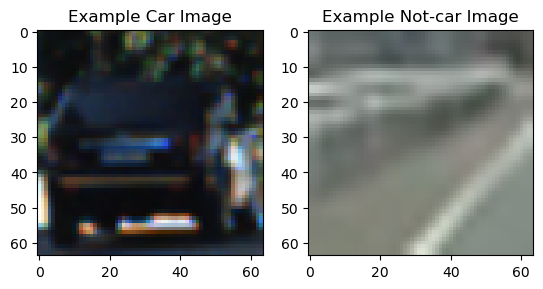

In [12]:
data_info = data_look(cars, notcars)

print('There are', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
car_image = imread(cars[car_ind])
notcar_image = imread(notcars[notcar_ind])

fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

### Extract Features

Try out hog feature on an image from each class from the dataset:

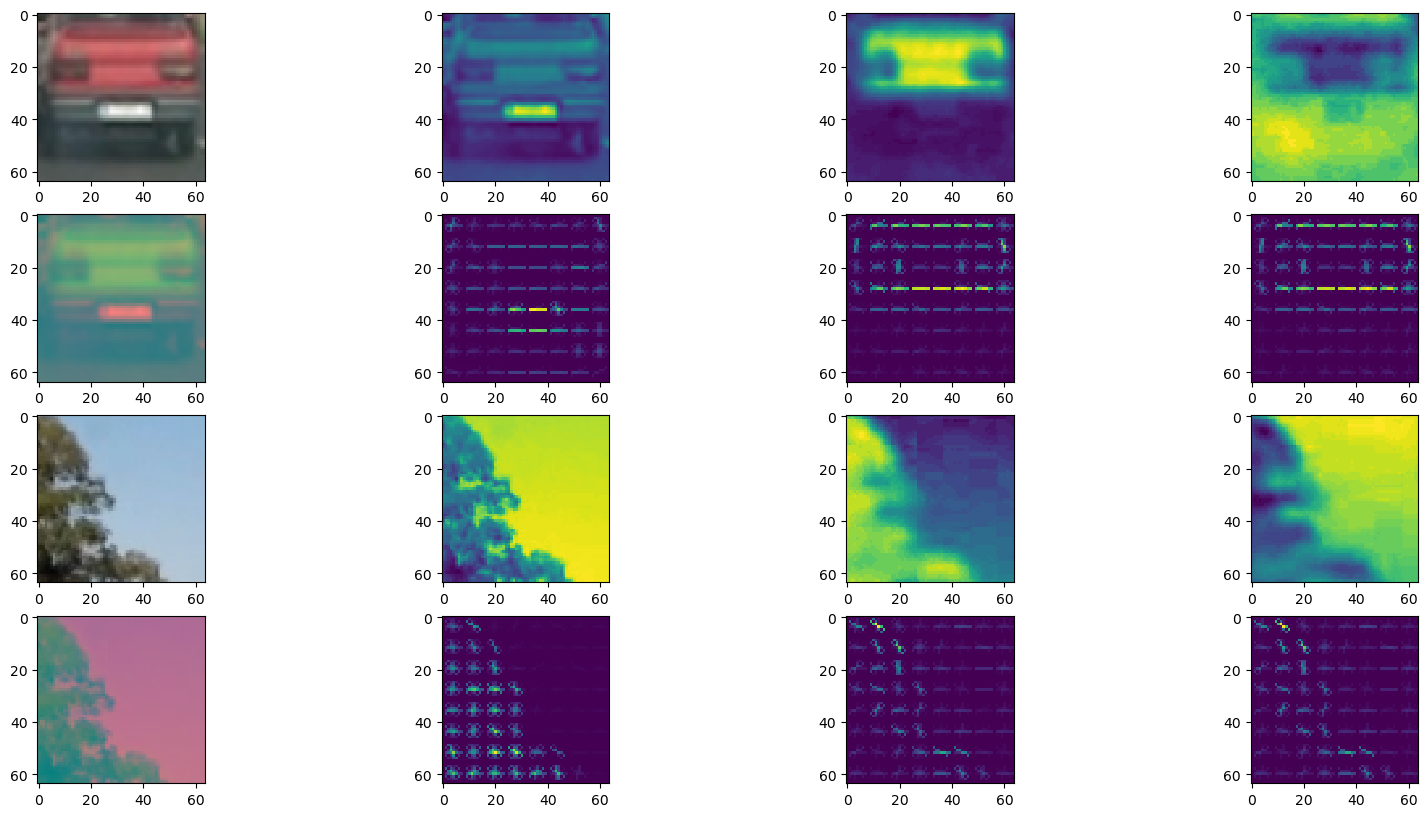

In [13]:
# Plot one random example for each class
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = imread(cars[car_ind])
notcar_image = imread(notcars[notcar_ind])

# Convert Images to YCrCb Space
ycrcb_car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)
ycrcb_notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2YCrCb)

# Extract Colour Channels
car_ch1 = ycrcb_car_image[:,:,0]
car_ch2 = ycrcb_car_image[:,:,1]
car_ch3 = ycrcb_car_image[:,:,2]

notcar_ch1 = ycrcb_notcar_image[:,:,0]
notcar_ch2 = ycrcb_notcar_image[:,:,1]
notcar_ch3 = ycrcb_notcar_image[:,:,2]

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

_, car_ch1_img = get_hog_features(car_ch1, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

_, car_ch2_img = get_hog_features(car_ch2, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

_, car_ch3_img = get_hog_features(car_ch3, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

_, notcar_ch1_img = get_hog_features(notcar_ch1, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

_, notcar_ch2_img = get_hog_features(notcar_ch2, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

_, notcar_ch3_img = get_hog_features(notcar_ch3, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

    
# Plot Results
f, axs = plt.subplots(4, 4, figsize=(20, 10))

# Original Image with YCrCb Channels
axs[0][0].imshow(car_image)
axs[0][1].imshow(car_ch1)
axs[0][2].imshow(car_ch2)
axs[0][3].imshow(car_ch3)

# YCrCb Image with Channel Gradients
axs[1][0].imshow(ycrcb_car_image)
axs[1][1].imshow(car_ch1_img)
axs[1][2].imshow(car_ch2_img)
axs[1][3].imshow(car_ch2_img)

# Original Image with YCrCb Channels

axs[2][0].imshow(notcar_image)
axs[2][1].imshow(notcar_ch1)
axs[2][2].imshow(notcar_ch2)
axs[2][3].imshow(notcar_ch3)

# YCrCb Image with Channel Gradients
axs[3][0].imshow(ycrcb_notcar_image)
axs[3][1].imshow(notcar_ch1_img)
axs[3][2].imshow(notcar_ch2_img)
axs[3][3].imshow(notcar_ch2_img)

plt.imsave("output_images/car_ch1_img.png", car_ch1_img)
plt.imsave("output_images/car_ch2_img.png", car_ch2_img)
plt.imsave("output_images/car_ch3_img.png", car_ch3_img)

plt.imsave("output_images/notcar_ch1_img.png", notcar_ch1_img)
plt.imsave("output_images/notcar_ch2_img.png", notcar_ch2_img)
plt.imsave("output_images/notcar_ch3_img.png", notcar_ch3_img)

Redefine the extraction functions, modified for the pipeline:

In [14]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # two outputs 
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):

    features = []
    for file in imgs:
        file_features = []
        image = imread(file)

        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)

        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)

        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)

        features.append(np.concatenate(file_features))

    return features

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

#### HOG Features
Extract only hog features for training

In [49]:
### Feacture Extraction Parmeters

hog_feat = True # HOG features on or off
color_space = 'YCrCb' #[RGB, HSV, LUV, HLS, YUV, YCrCb]
orient = 9 # HOG orientations
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (16, 16) # Spatial binning dimensions

hist_bins = 32    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

### Normalize Data

In [50]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

scaled_X = X_scaler.transform(X)

### Define Labels

In [51]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

### Split data into training and testing

In [52]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292


## Traing Model

Train the model that we will use for detections

In [53]:
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

0.24 Seconds to train SVC...


Test Accuracy

In [54]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  1.0


Saving model

In [24]:
import pickle
# Save the data for easy access
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
pickle.dump( dist_pickle, open( "svc_pickle.p", "wb" ) )


## Sliding Window Search

Define a function that takes an image, start and stop positions in both x and y, window size (x and y dimensions),  and overlap fraction (for both x and y), and returns a list of windows:

In [47]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    return window_list

Define a function to extract features from a single image. This function is very similar to extract_features(), but it just extracts features for a single image rather than a list of images.

In [48]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    
    img_features = []
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)      
        
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
        
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
        
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        img_features.append(hog_features)

    return np.concatenate(img_features)

Define a function you will pass an image and the list of windows to be searched (output of slide_windows())

In [56]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    on_windows = []
    
    for window in windows:
        
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        # Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        # Predict using your classifier
        prediction = clf.predict(test_features)
        
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    # Return windows for positive detections
    return on_windows

## Test Classifier on Image

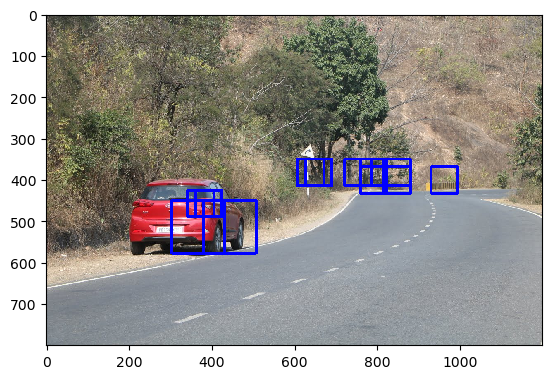

In [58]:
# Check the prediction time for a single sample
t=time.time()

image = imread('test_images/12.jpg')
draw_image = np.copy(image)

small_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[350, 500], 
                    xy_window=(64, 64), xy_overlap=(0.7, 0.7))

medium_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[450, 600], 
                    xy_window=(128, 128), xy_overlap=(0.7, 0.7))

large_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[500, None], 
                    xy_window=(256, 256), xy_overlap=(0.7, 0.7))

windows = small_windows + medium_windows + large_windows

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.imsave("output_images/testing_classifier_1.png", window_img)

## HOG Sub-sampling Window search

Function that can extract features using hog sub-sampling and makes predictions

In [61]:
import numpy as np
import cv2
from skimage.feature import hog

def convert_color(img, color_space='YCrCb'):
    
    feature_image = np.copy(img)
    # 2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    return feature_image


def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, draw_on_image=True):
    
    if draw_on_image:
        draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop, :, :]
    
    # Apply Conversion
    ctrans_tosearch = convert_color(img_tosearch, color_space='YCrCb')
    
    # Rescale Image 
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # Extract Colour Channels
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient * cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Array to store boxes
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(hog_features.reshape(1, -1))   
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                # Append Box
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
                # Flag for speeding processing on video
                if draw_on_image:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart), (0,0,255),6) 
    
    if draw_on_image:
        return bboxes, draw_img
    else:
        return bboxes

Test It

IndexError: index 6 is out of bounds for axis 0 with size 6

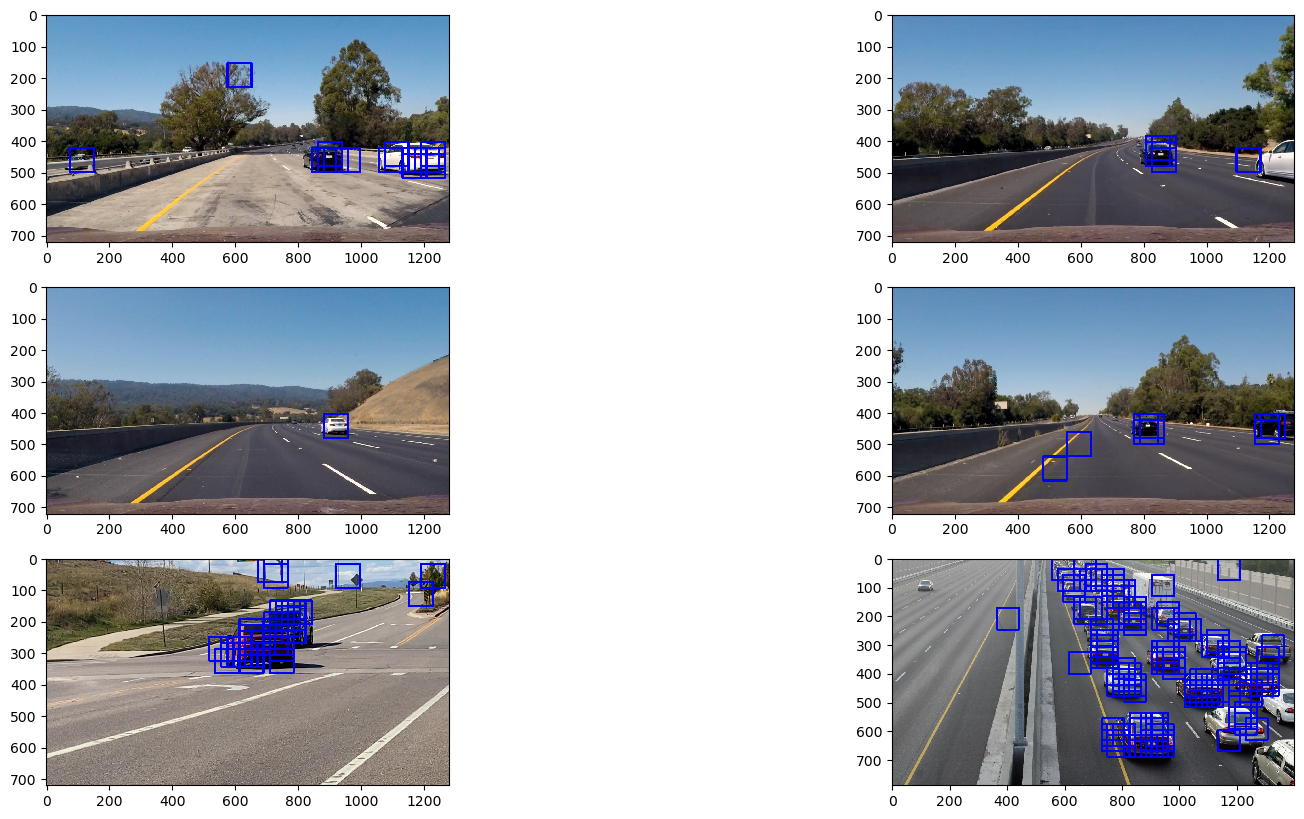

In [66]:
# Get Test Images Path
test_images = glob.glob('test_images/*.*')

# Tune Params
ystart = 0
ystop = 1200
scale = 1.2
cell_per_block = 2
pix_per_cell = 8
orient = 9

f, axs = plt.subplots(3, 2, figsize=(20, 10))
axs = axs.ravel()

i = 0

# Process all Images
for img in test_images:
    # Read Image
    tst_img = imread(img)
    
    # Find Cars
    boxes, out_img = find_cars(tst_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    
    # Display Boxes
    axs[i].imshow(out_img)
    
    # Get Image Name
    image_name = os.path.basename(img)
    
    # Save Image
    plt.imsave("output_images/{}-predicted.png".format(image_name[:-4]), out_img)
    
    i += 1
    
plt.show()

## Multiple Detections & False Positives

Create a heat-map from detections in order to combine overlapping detections and remove false positives.

Add heat (+1) for all pixesl within boxes:

In [64]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

Imposing a threshold to reject areas affected by false positives:

In [67]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

Function to draw bounding boxes around the labeled regions:

In [68]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
    # Return the image
    return img

Test It on above Image

IndexError: index 18 is out of bounds for axis 0 with size 18

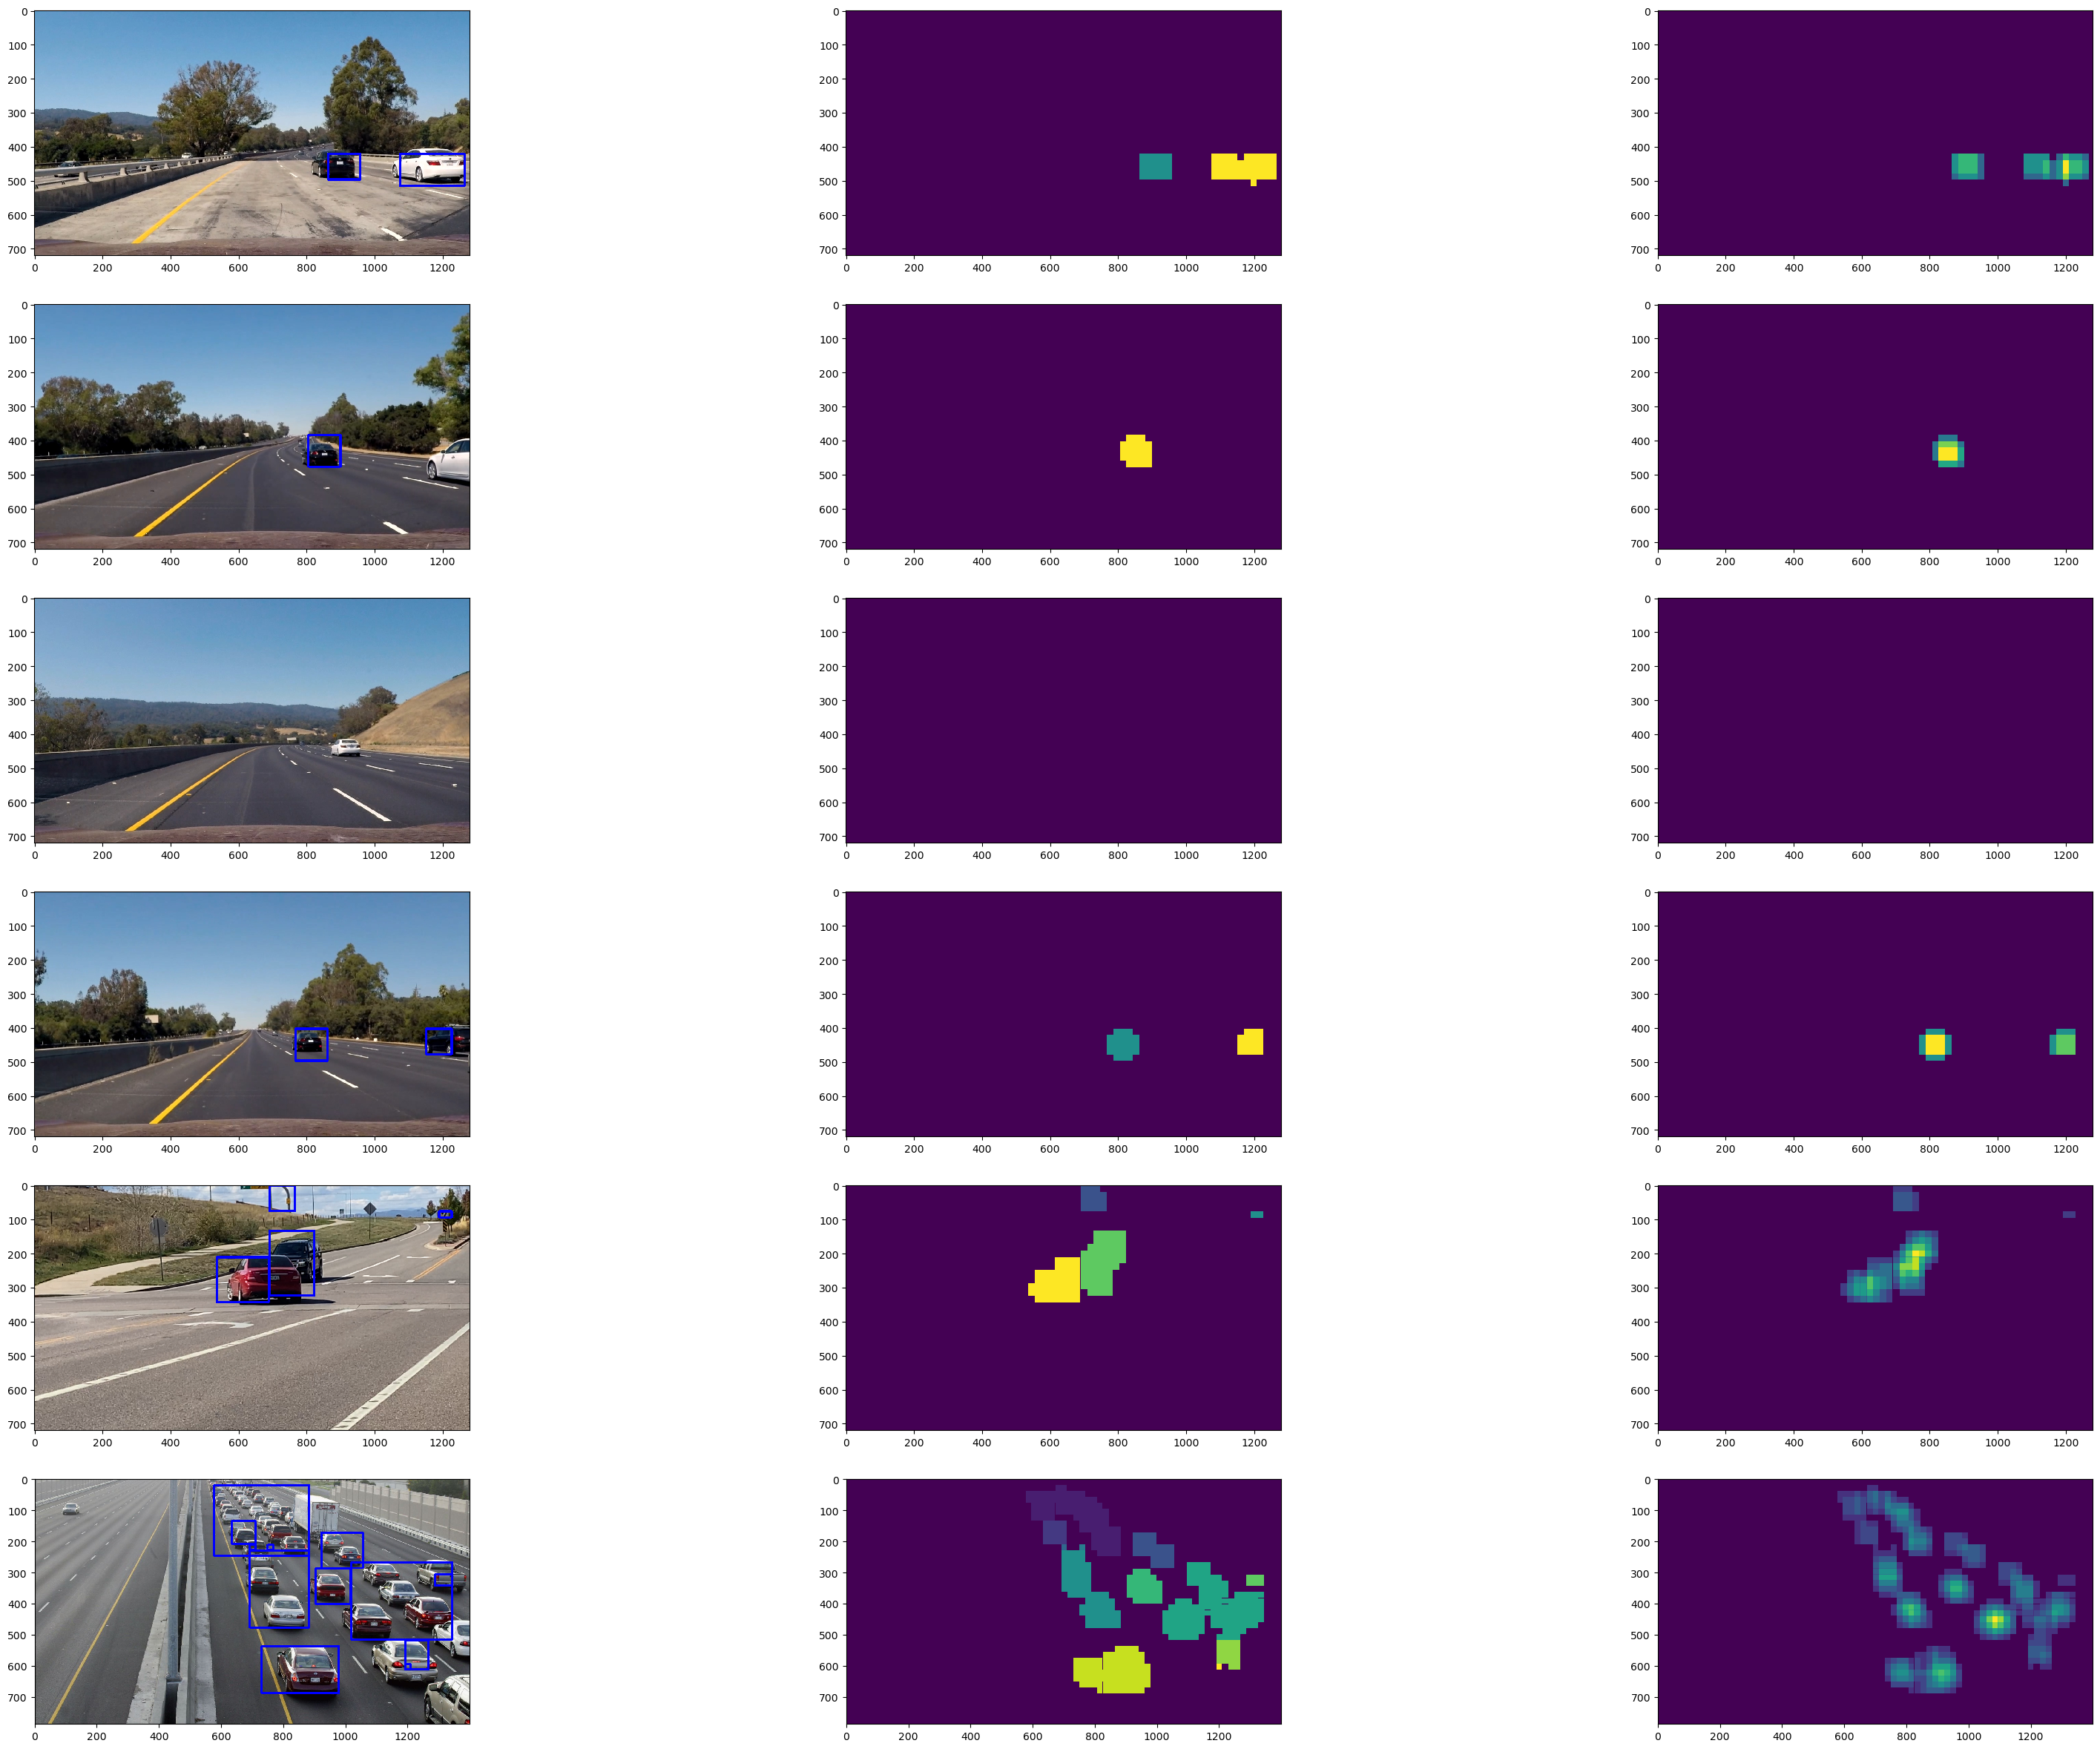

In [69]:
f, axs = plt.subplots(6, 3, figsize=(40, 30))
axs = axs.ravel()

i = 0

# Process all Images
for img in test_images:
    # Read Image
    tst_img = imread(img)
    
    # Find Cars
    box_list, out_img = find_cars(tst_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
   
        # Prepare heat map
    heat = np.zeros_like(out_img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(tst_img), labels)

    # Display Boxes
    axs[i].imshow(draw_img)
        
    # Display Labels
    axs[i + 1].imshow(labels[0])

    # Display Heatmap
    axs[i + 2].imshow(heatmap)
    
    i += 3
    
plt.show()

Put them all together in a single noise filter function:

In [72]:
def filter_noise(box_lists, heat, thresh=1):
    
    boxes = []
    for box_list in box_lists: 
        boxes = boxes + box_list
    
    # Add heat to each box in box list
    heat = add_heat(heat, boxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, thresh)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    return labels, heatmap

Integrate a heat map over several frames of video, such that areas of multiple detections get "hot", while transient false positives stay "cool".


## Vehicle Detection Pipeline:

Now we can put everything together in a single vehicle detection pipeline:

In [70]:
# Tune Params
ystart = 0
ystop = 1200
scale = 1.8
cell_per_block = 2
pix_per_cell = 8
orient = 9

class Counter():
    def __init__(self, n, thresh):
        self.MAX = n
        self.box_list = []
        self.thresh = thresh
        
def pipeline(img):
    
    image = np.copy(img)
    current_boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, draw_on_image=False)
    
    if len(counter.box_list) > counter.MAX:
        # FIFO stack of boxes
        counter.box_list = counter.box_list[1:]

    counter.box_list.append(current_boxes)
        
   # Prepare heat map
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    labels, heatmap = filter_noise(counter.box_list, heat, thresh=counter.thresh)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img

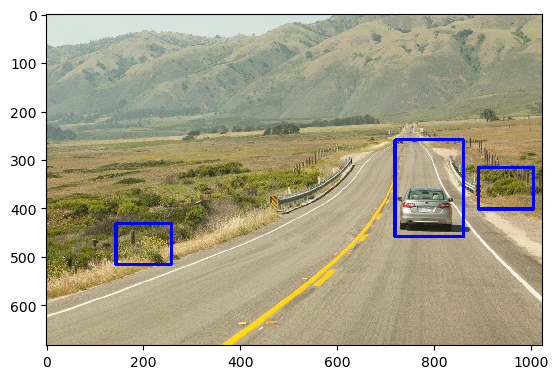

In [73]:
counter = Counter(10, 1)
imageTest = imread('test_images/13.jpg')
plt.imshow(pipeline(imageTest))